# Gas2Vec
Author: Michal Stary

This notebook contains adaptation of Spec2Vec for GC-MS data. 
 

## Settings

In [1]:
base = "data"
dataset = "nist"
kind = "de_novo"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

%load_ext autoreload
%autoreload 2

## Spectral data
We use the Spec2Vec and MatchMS libraries to load and preprocess spectral data.

Uncomment the pip install lines or run them directly in terminal

In [2]:
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument
from data_utils import spectrum_processing, get_n_samples
from data_utils import IntegerMzCoder, TextMzCoder, TopKDS, GenDS
import numpy as np
from gensim.models import Word2Vec

ModuleNotFoundError: No module named 'data_utils'

In [4]:
def load_process_documents(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents

documents_train = load_process_documents(data_train_path)

## Gas2Vec model
Load or train the w2v Gensim model using spec2vec library.

Either load pretrained file or uncomment the training and train your own.

In [ ]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_unique_file = f"gas2vec/{kind}3.model"
model_unique = train_new_word2vec_model(documents_train, iterations=list(range(0,10)), filename=model_unique_file,
                               workers=32, progress_logger=True, learning_rate_initial=0.01)

The value of learning_rate_initial is set from 0.025 (default) to 0.01
The value of workers is set from 4 (default) to 32
  Epoch 1 of 9.Change in loss after epoch 1: 854596.875
Saving model with name: gas2vec/de_novo3_iter_1.model
  Epoch 2 of 9.Change in loss after epoch 2: 1197873.875
Saving model with name: gas2vec/de_novo3_iter_2.model
  Epoch 3 of 9.Change in loss after epoch 3: 857958.75
Saving model with name: gas2vec/de_novo3_iter_3.model
  Epoch 4 of 9.Change in loss after epoch 4: 997299.5
Saving model with name: gas2vec/de_novo3_iter_4.model
  Epoch 5 of 9.Change in loss after epoch 5: 987134.5
Saving model with name: gas2vec/de_novo3_iter_5.model


In [ ]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_unique_file = f"gas2vec/{kind}2.model"
model_unique = train_new_word2vec_model(documents_train, iterations=list(range(0,153,2)), filename=model_unique_file,
                               workers=32, progress_logger=True, learning_rate_initial=0.01)

The value of learning_rate_initial is set from 0.025 (default) to 0.01
The value of workers is set from 4 (default) to 32
Warning! Number of total iterations is too high for given learning_rate decay.
Learning_rate_decay will be set from 0.00025 to 6.578947368421052e-05.
  Epoch 1 of 152.Change in loss after epoch 1: 1108743.625
  Epoch 2 of 152.Change in loss after epoch 2: 954604.625
Saving model with name: gas2vec/de_novo2_iter_2.model
  Epoch 3 of 152.Change in loss after epoch 3: 1009924.5
  Epoch 4 of 152.Change in loss after epoch 4: 1027443.5
Saving model with name: gas2vec/de_novo2_iter_4.model
  Epoch 5 of 152.Change in loss after epoch 5: 1007275.75
  Epoch 6 of 152.Change in loss after epoch 6: 968388.5
Saving model with name: gas2vec/de_novo2_iter_6.model
  Epoch 7 of 152.Change in loss after epoch 7: 903257.5
  Epoch 8 of 152.Change in loss after epoch 8: 945666.5
Saving model with name: gas2vec/de_novo2_iter_8.model
  Epoch 9 of 152.Change in loss after epoch 9: 954410.5

In [4]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_unique_file = f"gas2vec/{kind}.model"
model_unique = train_new_word2vec_model(documents_train, iterations=list(range(0,103,2)), filename=model_unique_file,
                               workers=32, progress_logger=True, learning_rate_initial=0.01)

The value of learning_rate_initial is set from 0.025 (default) to 0.01
The value of workers is set from 4 (default) to 32
Warning! Number of total iterations is too high for given learning_rate decay.
Learning_rate_decay will be set from 0.00025 to 9.80392156862745e-05.
  Epoch 1 of 102.Change in loss after epoch 1: 1089201.5
  Epoch 2 of 102.Change in loss after epoch 2: 1047996.0
Saving model with name: gas2vec/de_novo_iter_2.model
  Epoch 3 of 102.Change in loss after epoch 3: 1006778.0
  Epoch 4 of 102.Change in loss after epoch 4: 1013359.75
Saving model with name: gas2vec/de_novo_iter_4.model
  Epoch 5 of 102.Change in loss after epoch 5: 993349.75
  Epoch 6 of 102.Change in loss after epoch 6: 975245.5
Saving model with name: gas2vec/de_novo_iter_6.model
  Epoch 7 of 102.Change in loss after epoch 7: 961793.5
  Epoch 8 of 102.Change in loss after epoch 8: 997244.0
Saving model with name: gas2vec/de_novo_iter_8.model
  Epoch 9 of 102.Change in loss after epoch 9: 950727.0
  Epoch

## Evaluation of models' quality
To ensure which version of the model is the best, we compute the Tanimoto structural similarity of coumpounds in validation dataset and observe which checkpoint is most accurately predicting this similarity. 

We use the validation set of all dataset to test this.

In [5]:
# load val dataset
spectrums_val = [spectrum_processing(s) for s in load_from_msp(data_val_path)]
spectrums_val = [s for s in spectrums_val if s is not None]
spectrums_val = get_n_samples(spectrums_val, 5000, 42)

In [10]:
inchis = set()

spectrums_new = []
for s in spectrums_val:
    inchi_pref = s.metadata["inchikey"].split("-")[0]
    if inchi_pref in inchis:
        continue
    inchis.add(inchi_pref)
    spectrums_new.append(s)

In [11]:
len(spectrums_new)

4789

### Tanimoto similariry

In [12]:
#%pip install rdkit-pypi

from matchms import calculate_scores
from matchms import Spectrum
from matchms.filtering import add_fingerprint
from matchms.similarity import FingerprintSimilarity

def add_fingerprints_to_ds(ds):
    specs = [add_fingerprint(rec, nbits=2048) for rec in ds]
    return [s for s in specs if "fingerprint" in s.metadata]
def get_tanimoto_scores(ds):
    similarity_measure = FingerprintSimilarity("jaccard")
#     scores = calculate_scores(ds, ds, similarity_measure)
#     print(np.round(scores.scores, 3))
    return similarity_measure.matrix(ds, ds, is_symmetric=True)



In [13]:
spectrums_new = add_fingerprints_to_ds(spectrums_new)

RDKit ERROR: [21:04:58] SMILES Parse Error: syntax error while parsing: [Fe]|1|2|3|4(|N#CC(C#N|[Fe]|5|6(|N#CC(C#N|1)C(C#N)C#N)(|N#CC(C#N|2)C(C#N)C#N)|[PH+](CC(C)(C[PH+]|5(c7ccccc7)c8ccccc8)C[PH+]|6(c9ccccc9)c%10ccccc%10)(c%11ccccc%11)c%12ccccc%12)C(C#N)C#N)|[PH+](CC(C)(C[PH+]|3(c%13ccccc%13)c%14ccccc%14)C[PH+]|4(c%15ccccc%15)c%16ccccc%16)(c%17ccccc%17)c%18ccccc%18
RDKit ERROR: [21:04:58] SMILES Parse Error: Failed parsing SMILES '[Fe]|1|2|3|4(|N#CC(C#N|[Fe]|5|6(|N#CC(C#N|1)C(C#N)C#N)(|N#CC(C#N|2)C(C#N)C#N)|[PH+](CC(C)(C[PH+]|5(c7ccccc7)c8ccccc8)C[PH+]|6(c9ccccc9)c%10ccccc%10)(c%11ccccc%11)c%12ccccc%12)C(C#N)C#N)|[PH+](CC(C)(C[PH+]|3(c%13ccccc%13)c%14ccccc%14)C[PH+]|4(c%15ccccc%15)c%16ccccc%16)(c%17ccccc%17)c%18ccccc%18' for input: '[Fe]|1|2|3|4(|N#CC(C#N|[Fe]|5|6(|N#CC(C#N|1)C(C#N)C#N)(|N#CC(C#N|2)C(C#N)C#N)|[PH+](CC(C)(C[PH+]|5(c7ccccc7)c8ccccc8)C[PH+]|6(c9ccccc9)c%10ccccc%10)(c%11ccccc%11)c%12ccccc%12)C(C#N)C#N)|[PH+](CC(C)(C[PH+]|3(c%13ccccc%13)c%14ccccc%14)C[PH+]|4(c%15ccccc%15)c%1

In [14]:
import os
tanimoto_matrix_val = get_tanimoto_scores(spectrums_new)
#os.makedirs(f"gas2vec/similarity_{dataset}_val/{kind}", exist_ok=True)
#np.save(f"gas2vec/similarity_{dataset}_val/{kind}/tanimoto_scores", tanimoto_matrix_val)

#tanimoto_matrix_val = np.load(f"gas2vec/similarity_{dataset}_val/{kind}/tanimoto_scores.npy")

In [15]:
len(tanimoto_matrix_val[tanimoto_matrix_val != np.nan_to_num(tanimoto_matrix_val)])
#len(tanimoto_matrix_val.ravel())
len(tanimoto_matrix_val[np.isnan(tanimoto_matrix_val)])

0

<AxesSubplot:>

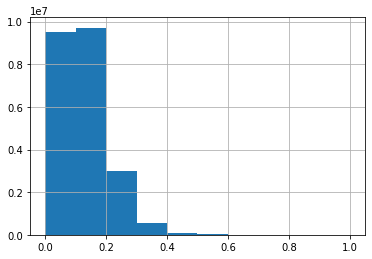

In [16]:
import pandas as pd
pd.Series(tanimoto_matrix_val.ravel()).hist()

### Similarity matrices lookalikeness
we will use  MSE weighted by the tanimoto score to measure the performance of g2v similarity measure. We will add weight 0 to main diagonal.


In [31]:
from sklearn.metrics import mean_squared_error

def tanimoto_weighted_mse(m_ref, m_pred):
    # get weights for mse
    weights = m_ref - np.eye(*m_ref.shape)
    
    return mean_squared_error(m_ref.ravel(), m_pred.ravel(), sample_weight=weights.ravel())

### Gas2Vec similarity

In [9]:
def get_best_ckpt(folder, model_base_file, spectrums_val, tanimoto_matrix_val):
    min_mse = None
    best_ckpt = None
    ckpt_to_mse = dict()
    ckpt_to_wmse = dict()
    ckpt_to_tmse = dict()
    
    def get_it(x):
        if "iter" not in x:
            return 1000
        return int(x.split(".")[0].split("_")[-1])
    
    for root, dirs, files in os.walk(folder):
        for ckpt in sorted([file for file in files if model_base_file.split(".")[0] in file], key=get_it):
            #print(ckpt)
            #continue
            w2v = Word2Vec.load(f"{folder}/{ckpt}") 
            
            gas2vec_similarity = Spec2Vec(model=w2v, intensity_weighting_power=0.5,
                               allowed_missing_percentage=15.0)
            
            gas2vec_matrix_val = gas2vec_similarity.matrix(spectrums_val, spectrums_val, is_symmetric=True)
            
            mse = mean_squared_error(tanimoto_matrix_val.ravel(), gas2vec_matrix_val.ravel())
            weighted_mse = tanimoto_weighted_mse(tanimoto_matrix_val, gas2vec_matrix_val)
            
            
            print(f"{ckpt}: mse: {mse:.3f} wmse:{weighted_mse:.3f}") #, tmse:{perc_mse:.3f}")
            ckpt_to_mse[ckpt] = mse
            ckpt_to_wmse[ckpt] = weighted_mse
           # ckpt_to_tmse[ckpt] = perc_mse
            
            if min_mse is None or weighted_mse < min_mse:
                min_mse = weighted_mse
                best_ckpt = ckpt
                
        return best_ckpt, min_mse, ckpt_to_mse, ckpt_to_wmse#, ckpt_to_tmse
selected = ""
best_ckpt_unique, min_mse_unique, ckpt_to_mse_unique, ckpt_to_wmse_unique = get_best_ckpt("gas2vec", f"{kind}{selected}.model", spectrums_new, tanimoto_matrix_val)
#best_ckpt_all, min_mse_all, ckpt_to_mse_all, ckpt_to_wmse_all = get_best_ckpt("gas2vec", "all.model", spectrums_val, tanimoto_matrix_val)

de_novo3_iter_1.model: mse: 0.021 wmse:0.025
de_novo_iter_2.model: mse: 0.019 wmse:0.025
de_novo2_iter_2.model: mse: 0.019 wmse:0.025
de_novo3_iter_2.model: mse: 0.019 wmse:0.026
de_novo3_iter_3.model: mse: 0.019 wmse:0.027
de_novo_iter_4.model: mse: 0.019 wmse:0.028
de_novo2_iter_4.model: mse: 0.019 wmse:0.028
de_novo3_iter_4.model: mse: 0.020 wmse:0.029
de_novo3_iter_5.model: mse: 0.019 wmse:0.028
de_novo_iter_6.model: mse: 0.019 wmse:0.028
de_novo2_iter_6.model: mse: 0.019 wmse:0.028
de_novo3_iter_6.model: mse: 0.019 wmse:0.029
de_novo3_iter_7.model: mse: 0.019 wmse:0.029
de_novo2_iter_8.model: mse: 0.019 wmse:0.028
de_novo3_iter_8.model: mse: 0.019 wmse:0.029
de_novo_iter_8.model: mse: 0.020 wmse:0.028
de_novo2_iter_10.model: mse: 0.019 wmse:0.028
de_novo_iter_10.model: mse: 0.019 wmse:0.029
de_novo_iter_12.model: mse: 0.019 wmse:0.028
de_novo2_iter_12.model: mse: 0.019 wmse:0.028
de_novo_iter_14.model: mse: 0.019 wmse:0.029
de_novo2_iter_14.model: mse: 0.020 wmse:0.029
de_novo_ite

In [10]:
sorted(ckpt_to_mse_unique.items(), key=lambda x: x[1])[:10]

[('de_novo_iter_96.model', 0.017911957983847933),
 ('de_novo2_iter_30.model', 0.01843620321972949),
 ('de_novo2_iter_2.model', 0.018664505480790357),
 ('de_novo3_iter_3.model', 0.018673059049269358),
 ('de_novo2_iter_28.model', 0.018709854175770608),
 ('de_novo_iter_2.model', 0.01873840758398107),
 ('de_novo2_iter_10.model', 0.018780889748799906),
 ('de_novo2_iter_36.model', 0.018789699196333276),
 ('de_novo_iter_94.model', 0.018841171709697273),
 ('de_novo2_iter_4.model', 0.018886032652384657)]

In [11]:
sorted(ckpt_to_wmse_unique.items(), key=lambda x: x[1])[:10]

[('de_novo3_iter_1.model', 0.02463905271988058),
 ('de_novo_iter_2.model', 0.025195820902498632),
 ('de_novo2_iter_2.model', 0.025395904959627194),
 ('de_novo3_iter_2.model', 0.026443025243549398),
 ('de_novo3_iter_3.model', 0.02727660382646991),
 ('de_novo3_iter_5.model', 0.027558777114560326),
 ('de_novo_iter_6.model', 0.02764763556589186),
 ('de_novo_iter_96.model', 0.027824580556257552),
 ('de_novo2_iter_4.model', 0.027968994244896503),
 ('de_novo_iter_4.model', 0.02801088453266155)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Text(0.5, 1.0, 'Gas2Vec')

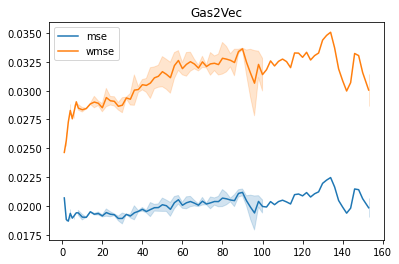

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# learning curve
def get_epochs(keyval):
    name, val = keyval
    splitted = name.split("_")
    if "iter" not in name:
        return 153
    else:
        return int(splitted[-1].split(".")[0])

def plot_err(dic, ax=None, label=None):
    itms = dic.items()
    mses = [it[1] for it in itms]
    epochs = [*map(get_epochs, itms)]
    return sns.lineplot(x=epochs, y=mses, ax=ax, label=label)

ax = plot_err(ckpt_to_mse_unique, label="mse")
plot_err(ckpt_to_wmse_unique, ax=ax, label="wmse")
#plot_err(ckpt_to_tmse_unique, ax=ax, label= "tmse")
plt.savefig(f"gas2vec/figures/{kind}/{selected}t.eps")
plt.savefig(f"gas2vec/figures/{kind}/{selected}t.pdf")
ax.set_title("Gas2Vec")


In [13]:
best_ckpt_unique

'de_novo3_iter_1.model'

## Load and inspect the best models

In [ ]:
#best_ckpt_unique = 'unique_iter_78.model'
#best_ckpt_unique = "in_database.model"

In [20]:
# load the models
# w2v_unique = Word2Vec.load(f"gas2vec/{best_ckpt_unique}")    
#w2v_all = Word2Vec.load(f"gas2vec/{best_ckpt_all}")   
w2v_unique = Word2Vec.load(f"gas2vec/{kind}.model")

## Evaluating the quality of peaks and spectral embeddings
Now we need to evaluate the peaks/spectral embeddings obtained by Spec2Vec.

Considering our usecases, we need to evaluate both peak (word) embeddings and spectral embeddings. 

**Peak embeddings evaluation**

Possible aproaches:
* Create LM on top of our peak embeddings, observe


**Spectral embeddings evaluation**

Possible aproaches: 

* Quantitative:
    * Design a similarity task (TANIMOTO )

## Create a spectral embedding 

In [21]:
from spec2vec import Spec2Vec
# Define similarity_function
gas2vec_similarity = Spec2Vec(model=w2v_unique, intensity_weighting_power=0.5, allowed_missing_percentage=15.0)

## Quantitative evaluation 
Evaluation based on comparison of somewhat "structural" TANIMOTO similarity (Jaccard on fingerprints) with Gas2Vec similarity and conventional cosine similarity. Same approach was used in original Spec2Vec paper. (modcos skipped due to its reliance on the precurosor that is available only in MS2)

In [22]:
spectrums_test = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(data_test_path)]
spectrums_test = [s for s in spectrums_test if s is not None]
spectrums_test = get_n_samples(spectrums_test, 5000)
spectrums_test = add_fingerprints_to_ds(spectrums_test)

RDKit ERROR: [21:08:31] SMILES Parse Error: syntax error while parsing: OC(=O)[C-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
RDKit ERROR: [21:08:31] SMILES Parse Error: Failed parsing SMILES 'OC(=O)[C-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: 'OC(=O)[C-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'


In [23]:
inchis = set()

spectrums_new = []
for s in spectrums_test:
    inchi_pref = s.metadata["inchikey"].split("-")[0]
    if inchi_pref in inchis:
        continue
    inchis.add(inchi_pref)
    spectrums_new.append(s)
    
spectrums_test=spectrums_new

### Tanimoto score

In [24]:
tanimoto_matrix = get_tanimoto_scores(spectrums_test)

### Modified cosine score 
Moreless conventional similarity on peaks used as a baseline. (see Spec2vec paper for author)

IMPOSSIBLE TO USE BEACUSE OF MISSING PRECURSOR MZ!!

In [25]:
# from matchms.similarity import ModifiedCosine
# # same tolerance as in spec2vec paper
# modcos_similarity = ModifiedCosine(tolerance=0.005)

# modcos_scores = calculate_scores(spectrums, spectrums, modcos_similarity)

### Cosine score 
Conventional similarity on peaks used as a baseline. 

In [26]:
from matchms.similarity import CosineGreedy

def cosine_sim(spectrums_test):
    # same tolerance as in spec2vec paper
    cosine_similarity = CosineGreedy(tolerance=0.005)

    cosine_pairs = cosine_similarity.matrix(spectrums_test, spectrums_test, is_symmetric=True)

    # divide into similarity and matches

    cosine_matrix = np.zeros_like(cosine_pairs, dtype=float)
    cosine_matches = np.zeros_like(cosine_matrix, dtype=int)
    for i in range(cosine_pairs.shape[0]):
        for j in range(cosine_pairs.shape[1]):
            cosine_matrix[i][j] = cosine_pairs[i][j][0]
            cosine_matches[i][j] = cosine_pairs[i][j][1]
            
    return cosine_matrix, cosine_matches

cosine_matrix, cosine_matches = cosine_sim(spectrums_test)
#cosine_matrix = np.load(f"gas2vec/similarity_{dataset}/cos_scores.npy")
#cosine_matches = np.load(f"gas2vec/similarity_{dataset}/cos_matches_scores.npy")

### Weighted cosine score 
Conventional similarity on peaks used as a baseline. 

In [27]:
from matchms.similarity import CosineGreedy

def wcosine_sim(spectrums_test):
    # same tolerance as in spec2vec paper
    cosine_similarity = CosineGreedy(tolerance=0.005, mz_power=1, intensity_power=0.5)

    cosine_pairs = cosine_similarity.matrix(spectrums_test, spectrums_test, is_symmetric=True)

    # divide into similarity and matches

    cosine_matrix = np.zeros_like(cosine_pairs, dtype=float)
    cosine_matches = np.zeros_like(cosine_matrix, dtype=int)
    for i in range(cosine_pairs.shape[0]):
        for j in range(cosine_pairs.shape[1]):
            cosine_matrix[i][j] = cosine_pairs[i][j][0]
            cosine_matches[i][j] = cosine_pairs[i][j][1]
            
    return cosine_matrix, cosine_matches

wcosine_matrix, wcosine_matches = wcosine_sim(spectrums_test)
#cosine_matrix = np.load(f"gas2vec/similarity_{dataset}/cos_scores.npy")
#cosine_matches = np.load(f"gas2vec/similarity_{dataset}/cos_matches_scores.npy")

### Gas2Vec unique score

In [28]:
gas2vec_matrix = gas2vec_similarity.matrix(spectrums_test, spectrums_test, is_symmetric=True)

### Gas2Vec all score

In [29]:
# gas2vec_all_matrix = gas2vec_similarity_all.matrix(spectrums_test, spectrums_test, is_symmetric=True)

### MSE cosine vs gas2vec

In [32]:
mse_g2v = mean_squared_error(gas2vec_matrix, tanimoto_matrix)
# mse_g2v_all = mean_squared_error(gas2vec_all_matrix, tanimoto_matrix)
mse_cos = mean_squared_error(cosine_matrix, tanimoto_matrix)
mse_wcos = mean_squared_error(wcosine_matrix, tanimoto_matrix)

In [33]:
print("Gas2Vec unique MSE: ", mse_g2v)
print("Cosine MSE: ", mse_cos)
print("wCosine MSE: ", mse_wcos)

Gas2Vec unique MSE:  0.020938613963006156
Cosine MSE:  0.017749087904999034
wCosine MSE:  0.01592286463304963


In [34]:
wmse_g2v = tanimoto_weighted_mse(gas2vec_matrix, tanimoto_matrix)
# wmse_g2v_all = tanimoto_weighted_mse(gas2vec_all_matrix, tanimoto_matrix)
wmse_cos = tanimoto_weighted_mse(cosine_matrix, tanimoto_matrix)
wmse_wcos = tanimoto_weighted_mse(wcosine_matrix, tanimoto_matrix)

In [35]:
print("Gas2Vec unique wMSE: ", wmse_g2v)
print("Cosine wMSE: ", wmse_cos)
print("wCosine wMSE: ", wmse_wcos)

Gas2Vec unique wMSE:  0.03216595975218862
Cosine wMSE:  0.04215271188982673
wCosine wMSE:  0.02823057025981113


### Final comparison
Let's avoid reinvetning the wheel and use slightly modified notebooks provided by authors of Spec2Vec for comparison of above computed method. 

We save the similarities in form of numpy file matrices to load them in those notebooks. 

For the final comparison we use spec2vec-score_comparison.ipynb and spec2vec-score_comparison2.ipynb. (supplied on demand)

In [36]:
import os

os.makedirs(f"gas2vec/similarity_{dataset}/{kind}", exist_ok=True)

scores = [tanimoto_matrix, gas2vec_matrix, cosine_matrix, cosine_matches, wcosine_matrix, wcosine_matches ]
descriptions = ["tani", "g2v", "cos", "cos_match", "wcos", "wcos_match"]

for score_matrix, scores_name in zip(scores, descriptions):
    np.save(f"gas2vec/similarity_{dataset}/{kind}/{scores_name}_scores", score_matrix)